A Python deep learning framework for forecasting Atlantic hurricane intensity using LSTM.

## Data
The following dataset will be used to create the model:

NHC Hurricane Database (HURDAT2):
    http://www.nhc.noaa.gov/data/#hurdat

This dataset (known as Atlantic HURDAT2) has a comma-delimited, text format with six-hourly information on the location, maximum winds, central pressure, and (beginning in 2004) size of all known tropical cyclones and subtropical cyclones.

The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2018.

## Extract Data
We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL.

In [1]:
# The code was removed by Watson Studio for sharing.

## Data Preprocessing

In [2]:
# Decode a botocore.response.StreamingBody binary object
msg = streaming_body_1.read().decode("utf-8")

import io
buf = io.StringIO(msg)
# buf.readline()

import datetime

temp_entries = []

for line in buf:
    line = line.replace(' ', '').split(',')
    # print(line[0][:2])
    
    # Identify atlantic storm, first 2 letters should be AL
    if (line[0][:2] == 'AL'):
        storm_id = line[0]
        storm_name = line[1]
        storm_entries = line[2]
    
        # Iterate and read through best track entries
        for i in range(int(storm_entries)):
            entry = buf.readline().replace(' ', '').split(',')
            # Filter -999 placeholder for missing central pressure
            entry = [None if x == "-999" else x for x in entry]
            # Construct date and time based on first two columns
            timestamp = datetime.datetime(int(entry[0][:4]), int(entry[0][4:6]), int(entry[0][6:8]), int(entry[1][:2]), int(entry[1][3:]))
            # Add entry into our current database
            temp_entries.append([storm_id, storm_name, timestamp] + entry[2:-1])
        
    else:
        print("Error, unidentified storm ".join(str(line[0])))

# Create the dataframe
df = pd.DataFrame(temp_entries, columns = ['storm_id', 'storm_name', 'entry_time', 'entry_id', 'entry_status', 'lat', 'long','max_wind', 'min_pressure', '34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'])

df=df.set_index('entry_time', drop=True, append=False, inplace=False, verify_integrity=False)

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
df.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,34kt_se,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
entry_time,,,,,,,,,,,,,,,,,,,,
2005-08-23 18:00:00,AL122005,KATRINA,,TD,23.1N,75.1W,30,1008,0,0,0,0,0,0,0,0,0,0,0,0
2005-08-24 00:00:00,AL122005,KATRINA,,TD,23.4N,75.7W,30,1007,0,0,0,0,0,0,0,0,0,0,0,0
2005-08-24 06:00:00,AL122005,KATRINA,,TD,23.8N,76.2W,30,1007,0,0,0,0,0,0,0,0,0,0,0,0
2005-08-24 12:00:00,AL122005,KATRINA,,TS,24.5N,76.5W,35,1006,60,60,0,0,0,0,0,0,0,0,0,0
2005-08-24 18:00:00,AL122005,KATRINA,,TS,25.4N,76.9W,40,1003,60,60,0,0,0,0,0,0,0,0,0,0


In [3]:
# Delete the columns of information that we are not using so far
df=df.drop(['entry_id','entry_status','34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'],axis=1,inplace = False)
df.head()

,storm_id,storm_name,lat,long,max_wind,min_pressure
entry_time,,,,,,
1851-06-25 00:00:00,AL011851,UNNAMED,28.0N,94.8W,80,None
1851-06-25 06:00:00,AL011851,UNNAMED,28.0N,95.4W,80,None
1851-06-25 12:00:00,AL011851,UNNAMED,28.0N,96.0W,80,None
1851-06-25 18:00:00,AL011851,UNNAMED,28.1N,96.5W,80,None
1851-06-25 21:00:00,AL011851,UNNAMED,28.2N,96.8W,80,None


Now that we have the data in an easy-to-use form, we can create a quick plot of each series and see what we have.

It is easier for the neural network to learn from distance vectors rather than from latitude and longitude that contain negative values. To preprocess the data, the angle of travel and distance between each given point will be calculated and added.

In [4]:
# split coordinate in 3 components and cast them to numbers
decimal_coordinate_lat = []
decimal_coordinate_lng = []

temp_lat = df['lat'].values
temp_lng = df['long'].values


for coordinate in temp_lat:
    # generate the decimal multiplier (if coordinate is S or V, then the
    # decimal representation is negative
    multiplier = 1
    if coordinate.endswith('S'):
        multiplier = -1
    # split coordinate in 3 components and cast them to numbers
    components = coordinate[:-1].split('.')
    degrees = int(components[0])
    minutes = int(components[1])
    # compute decimal coordinate with max 5 decimals
    decimal_coordinate_lat.append(float("{0:.5f}".format(multiplier * degrees + (minutes / 60))))
    
for coordinate in temp_lng:
    # generate the decimal multiplier (if coordinate is S or W, then the
    # decimal representation is negative
    multiplier = 1
    if coordinate.endswith('W'):
        multiplier = -1
    # split coordinate in 3 components and cast them to numbers
    components = coordinate[:-1].split('.')
    degrees = int(components[0])
    minutes = int(components[1])
    # compute decimal coordinate with max 5 decimals
    decimal_coordinate_lng.append(float("{0:.5f}".format(multiplier * degrees + (minutes / 60))))
    
df['lat'] = decimal_coordinate_lat
df['long'] = decimal_coordinate_lng

Drop rows with any NA, None, etc values as well as any useless information

In [5]:
# Drop rows with any NA, None, etc values
# df = df.dropna(inplace=False)
df.fillna(value=-999, inplace=True)

# Drop 'storm_id' & 'storm_name'
df.drop(['storm_id','storm_name'],axis=1,inplace = True)
df

,lat,long,max_wind,min_pressure
entry_time,,,,
1851-06-25 00:00:00,28.00000,-93.86667,80,-999
1851-06-25 06:00:00,28.00000,-94.93333,80,-999
1851-06-25 12:00:00,28.00000,-96.00000,80,-999
1851-06-25 18:00:00,28.01667,-95.91667,80,-999
1851-06-25 21:00:00,28.03333,-95.86667,80,-999
1851-06-26 00:00:00,28.03333,-97.00000,70,-999
1851-06-26 06:00:00,28.05000,-96.90000,60,-999
1851-06-26 12:00:00,28.06667,-97.95000,60,-999
1851-06-26 18:00:00,28.10000,-97.85000,50,-999


In [6]:
df

,lat,long,max_wind,min_pressure
entry_time,,,,
1851-06-25 00:00:00,28.00000,-93.86667,80,-999
1851-06-25 06:00:00,28.00000,-94.93333,80,-999
1851-06-25 12:00:00,28.00000,-96.00000,80,-999
1851-06-25 18:00:00,28.01667,-95.91667,80,-999
1851-06-25 21:00:00,28.03333,-95.86667,80,-999
1851-06-26 00:00:00,28.03333,-97.00000,70,-999
1851-06-26 06:00:00,28.05000,-96.90000,60,-999
1851-06-26 12:00:00,28.06667,-97.95000,60,-999
1851-06-26 18:00:00,28.10000,-97.85000,50,-999


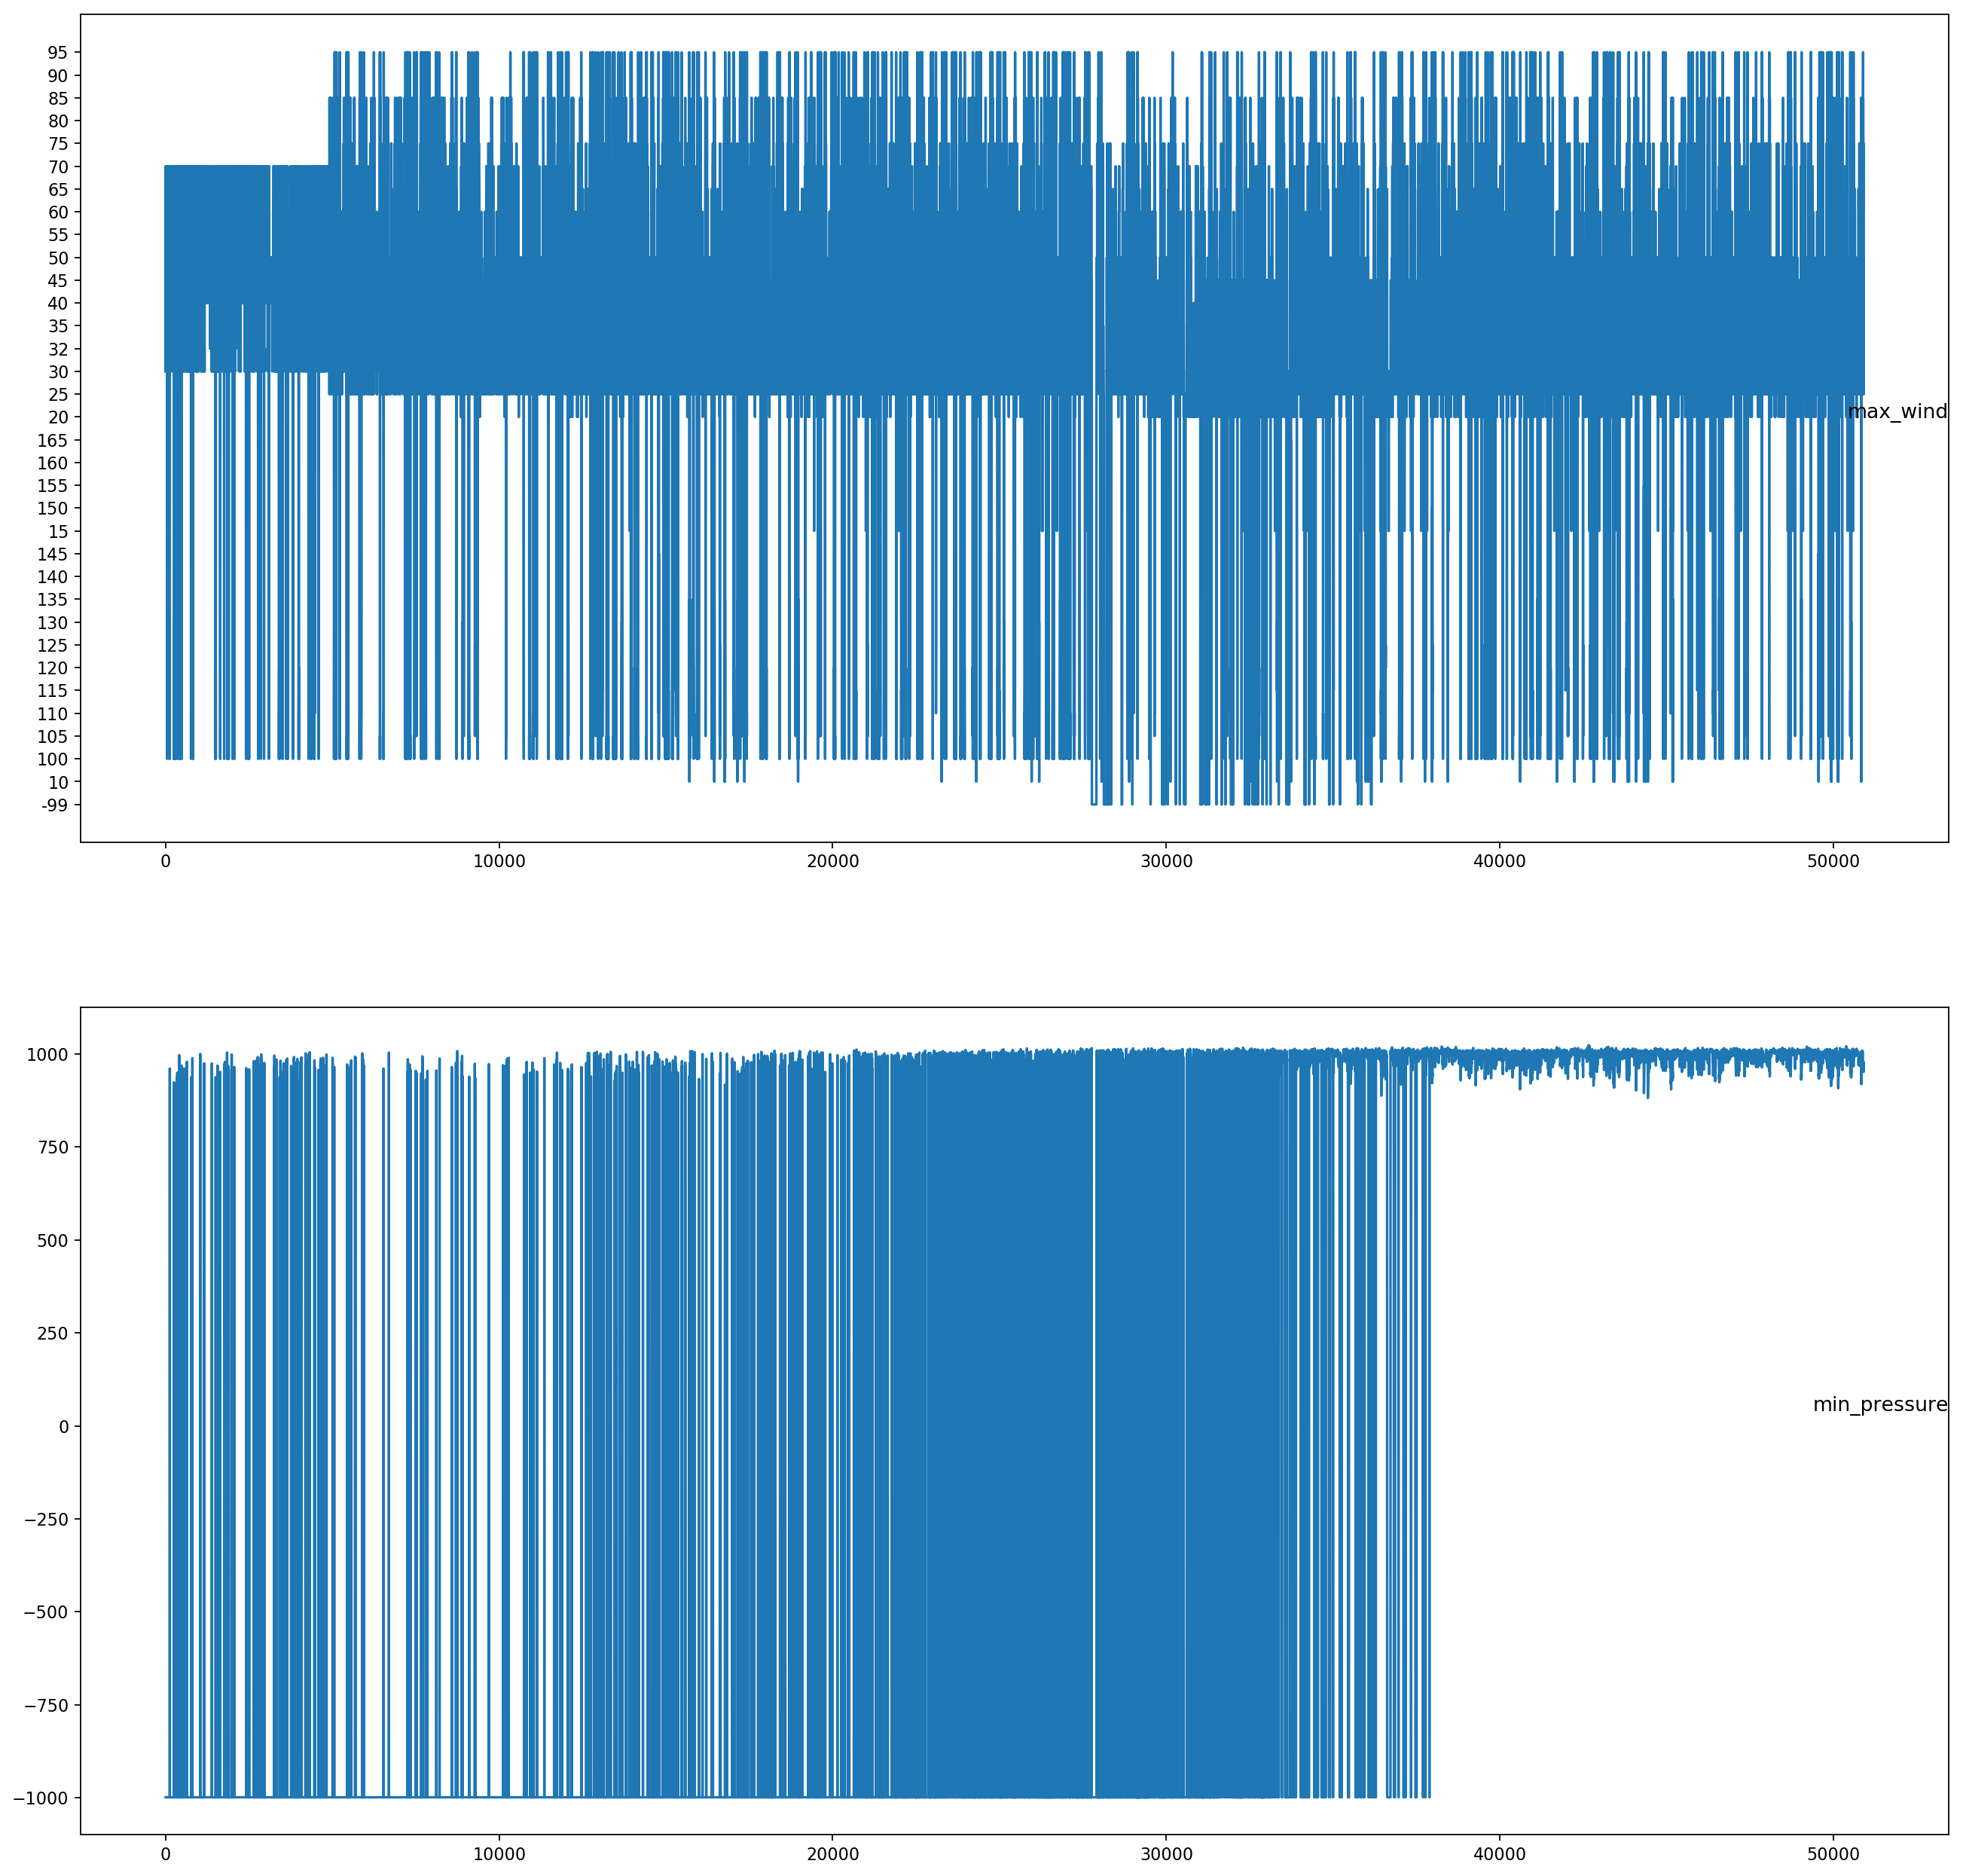

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib import pyplot

values = df.values
# specify columns to plot
groups = [2,3]
i = 1
# plot each column
plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

We will frame the supervised learning problem as predicting the wind speed at the current hour (t) given the           at the prior time step (6 hours ago).

In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# Ensure all data is float
values = values.astype('float32')
# Normalize features
# Feature Scaling From previous experience with deep learning models, we know that we 
# have to scale our data for optimal performance. In our case, we’ll use Scikit- Learn’s 
# MinMaxScaler and scale our dataset to numbers between zero and one.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed

# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

Using TensorFlow backend.


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.283461   0.087985    0.67803        0.0  0.283461
2   0.283461   0.081783    0.67803        0.0  0.283461
3   0.283461   0.075581    0.67803        0.0  0.283686
4   0.283686   0.076066    0.67803        0.0  0.283912
5   0.283912   0.076357    0.67803        0.0  0.283912


## Define and Fit Model
We will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. We will fit the model on the 130 year of data, then evaluate it on the remaining years of data.

We split the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [20]:
# split into train and test sets
values = reframed.values

# fit the model on the x year of data
test_perc = 0.2
train = values[:int(values.shape[0]*(1-test_perc)), :]
test = values[int(values.shape[0]*(1-test_perc)):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# The shape on the input to the LSTM will be in a 3D array [samples, timestamps, features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(40728, 1, 4) (40728,) (10182, 1, 4) (10182,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting wind speed. The input shape will be 1 time step with 8 features.

We will use the Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch.

Finally, we keep track both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

Train on 40728 samples, validate on 10182 samples
Epoch 1/50
 - 10s - loss: 0.0100 - val_loss: 0.0030
Epoch 2/50
 - 10s - loss: 0.0031 - val_loss: 0.0029
Epoch 3/50
 - 10s - loss: 0.0030 - val_loss: 0.0029
Epoch 4/50
 - 10s - loss: 0.0030 - val_loss: 0.0029
Epoch 5/50
 - 10s - loss: 0.0030 - val_loss: 0.0028
Epoch 6/50
 - 10s - loss: 0.0030 - val_loss: 0.0028
Epoch 7/50
 - 10s - loss: 0.0029 - val_loss: 0.0028
Epoch 8/50
 - 10s - loss: 0.0029 - val_loss: 0.0028
Epoch 9/50
 - 10s - loss: 0.0029 - val_loss: 0.0028
Epoch 10/50
 - 10s - loss: 0.0029 - val_loss: 0.0028
Epoch 11/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 12/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 13/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 14/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 15/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 16/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 17/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch 18/50
 - 10s - loss: 0.0029 - val_loss: 0.0027
Epoch

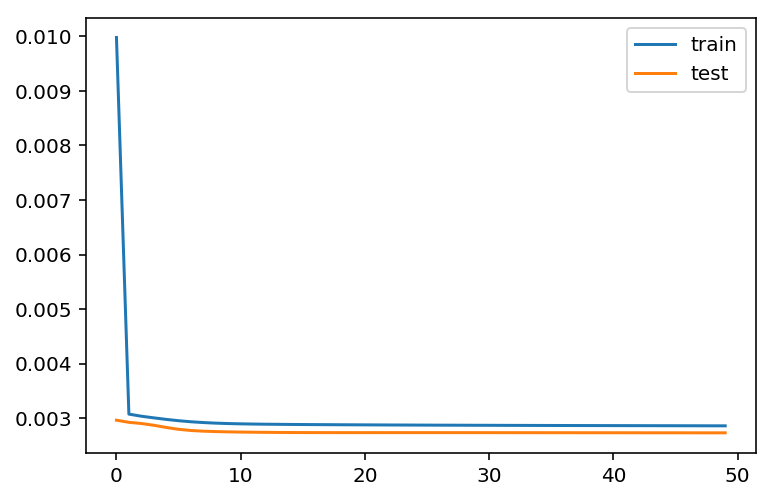

In [21]:
# Design network
# Start neural network
model = Sequential()
# Add a long short-term memory layer with 50 units (number of neurons or nodes that we want in the layer)
model.add(LSTM(50, # 50 units
               input_shape=(train_X.shape[1], # number of time steps
                            train_X.shape[2] # number of indicators
                           )))
# Add fully connected layer with a sigmoid activation function
# The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.
model.add(Dense(1))
# Compile neural network
model.compile(loss='mse', # mean squared error as loss function
              optimizer='adam' # Adam optimization to reduce the loss or to optimize the algorithm
             )
# Fit network
history = model.fit(train_X,# Features
                    train_y,# Target
                    epochs=50,# Number of epochs
                    batch_size=72,# Number of observations per batch
                    validation_data=(test_X, test_y),# Data for evaluation
                    verbose=2,# Print some description after each epoch
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Training loss is not much lower than validation loss, which may indicate that the network might not be overfitting. 

## Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected wind speed numbers (transform can be inverted). This is useful for converting predictions back into their original scale for reporting or plotting. This can be done by calling the inverse_transform() function.

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.866
